In [1]:
import sys

In [2]:
#Making Surface mapping code available for analysis
sys.path.insert(1, '../src/')

In [3]:
from QuasiPotential import *
import gillespie
from matplotlib import pyplot as plt
from scipy.interpolate import griddata
from scipy.stats import gaussian_kde
import numpy as np
import random

# Tristable Toggle Switch

## Integrating individual Trajectory

### Defining the system

In [4]:
#Symbolic system
x,y,fxy, fyx,fxx,fyy, KDyx, KDxy, KDxx, KDyy, Bx, By, degx, degy, n = sm.symbols(
    'x,y,fyx,fxy,fxx,fyy  KDyx, KDxy, KDxx, KDyy, Bx, By, degx, degy, n'
)


#System of equations
xdot = Bx + (fxx*x**n/(KDxx**n + x**n)) + (fyx*KDyx**n/(KDyx**n + y**n)) - degx*x
ydot = By + fyy*y**n/(KDyy**n + y**n) + fxy*KDxy**n/(KDxy**n + x**n) - degy*y

#lambdify expression
dxdt = sm.lambdify((x,y,fyx,fxy,fxx,fyy,  KDyx, KDxy, KDxx, KDyy, Bx, By, degx, degy, n), xdot)
dydt = sm.lambdify((x,y,fyx,fxy,fxx,fyy, KDyx, KDxy, KDxx, KDyy, Bx, By, degx, degy, n), ydot)

#Define system in single function
def toggle_switch(z0, t, *p):
    x,y = z0
    del_x = dxdt(x,y,*p)
    del_y = dydt(x,y,*p)
    return [del_x, del_y]

### Integrating potential path along said system

In [5]:
#Setting ODE Parameters
params = (10,10,10,10,4,4,4,4,0,4,1,1,10)#fyx,fxy,fxx,fyy  KDyx, KDxy, KDxx, KDyy, Bx, By, degx, degy, n

#Integration Parameters
initials = [55, 55] #x0, y0
t0 = 0 #initial time
v0 = 0 #inital potential value
tol = 1e-5 #convergence criterion
tstep = 0.05 #time step



xy_path, v_path, times = integrate_potential_path(toggle_switch, initials, t0, v0, tol, tstep, *params)

### Plottting Results

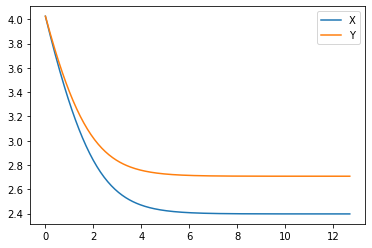

In [6]:
#Plot the trajectories with respect to time
x_path, y_path = zip(*xy_path)
plt.plot(times, np.log1p(x_path), label = "X")
plt.plot(times, np.log1p(y_path), label = "Y")
# plt.plot(times, v_path, label = "V")
plt.legend()
plt.show()

# Approximating the Potential Surface

In [16]:
#Setting up grid parameters
xy_min = 0.0
xy_max = 55.0
xy_step = 0.5

#integration parameters
int_params = (t0, v0, tol, tstep)

#Calculating and aligning Quasipotential trajectories with different inits along a 2d grid
x_paths, y_paths, v_paths, attractors = QuasiPotential2D(toggle_switch, params, int_params, xy_min, 
                                                         xy_max, xy_step,attractor_tol = 1e-2,  n_jobs = -1)

In [17]:
print("num attractors = ", len(attractors))

num attractors =  2


### Interpolate through trajectories to map surface

In [18]:
xs = []
ys = []
Vs = []

for x, y, v in zip(x_paths, y_paths, v_paths):
    xs += list(x)
    ys += list(y)
    Vs += list(v)
    
gridlines = 100

x_grid = np.linspace(min(xs), max(xs), gridlines)
y_grid = np.linspace(min(ys), max(ys), gridlines)

X_grid,Y_grid = np.meshgrid(x_grid, y_grid)
V_grid = griddata((xs,ys),Vs, (X_grid, Y_grid))

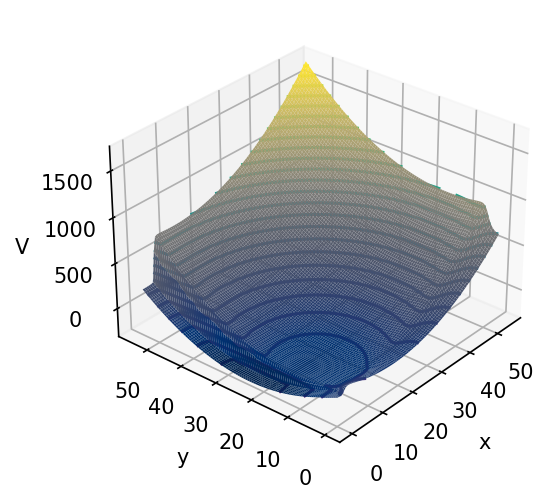

In [19]:
fig = plt.figure(dpi = 150)
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X_grid, Y_grid, V_grid, cmap="cividis", lw=0.5, rstride=1, cstride=1)
ax.contour(X_grid, Y_grid, V_grid, 30, linestyles="solid")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('V')

ax.view_init(30, -140)

plt.show()

### Stochastic Simulations

#### Simulate and plot one trajectory

In [20]:
# Code adapted from Sueskind: https://github.com/sueskind/gillespie
random.seed(a = 42)

# Initial conditions for stochastic simulation
initials = [20, 5]

# Parameters
fold_yx, fold_xy, fold_xx, fold_yy,  k_yx, k_xy, k_xx, k_yy, b_x, b_y, d_x, d_y, n = (
    10, 10, 10, 10, 4, 4, 4, 4, 0.0, 4.0, 1, 1, 10
)

# Propensities
#  - A list of functions that, given the values of your current states, compute the transition rate of a reaction:
def x_birth(x,y):
    return b_x + fold_xx*x**n/(k_xx**n + x**n) + fold_yx*k_yx**n/(k_yx**n + y**n)
def y_birth(x,y):
    return b_y + fold_yy*y**n/(k_yy**n + y**n) + fold_xy*k_xy**n/(k_xy**n + x**n)
def x_death(x,y):
    return d_x*x
def y_death(x,y):
    return d_y*y

propensities = [
    x_birth,
    y_birth,
    x_death,
    y_death
]

# Stoichiometries
# Positive terms in the differential equations are considered as "birth" (+1 in stoich)
# Negative terms in the differential equations are considered as "death" (-1 in stoich)
stoichiometry = [
    [1,0],
    [0,1],
    [-1,0],
    [0,-1]
         ]

In [21]:
#Initialize Number of runs
runs = 10000
t_runs = {}
X_runs = {}
Y_runs = {}
V_runs = {}

#Define parallelizable gillespie function for asynchronous simulations
def gillespie_sim(r, initials, propoensities, stoichiometry, duration):
    times, XY_stoch = gillespie.simulate(initials, propensities, stoichiometry, duration)
    return (r, times, XY_stoch)

#Run simulations in parallel
pool = mp.Pool(mp.cpu_count())
results = []
results = pool.starmap_async(gillespie_sim, [(r, initials, propensities, stoichiometry, 50) for r in range(runs)]).get()

#Close pool after finished
pool.close()

#### Calculate potential for each point along trajectory

In [22]:
x_grid_step = (max(xs) - min(xs)) / gridlines
print(x_grid_step)

0.545


In [23]:
y_grid_step = (max(ys) - min(ys)) / gridlines
print(y_grid_step)

0.545


In [25]:
max([max(Y_runs[r]) for r in range(runs)])

52

In [24]:
#Collect results into dictionary
for result in results:
    r = result[0]
    t_runs[r] = result[1]
    X_stoch, Y_stoch = zip(*result[2])
    X_runs[r] = X_stoch
    Y_runs[r] = Y_stoch
    V_stoch = []
    for i in range(0, len(X_stoch)):
        x_idx = int(X_stoch[i] / x_grid_step)
        y_idx = int(Y_stoch[i] / y_grid_step)
        V_stoch.append(V_grid[y_idx, x_idx])
    V_runs[r] = V_stoch

#### Overlay stoch traj on potential surface

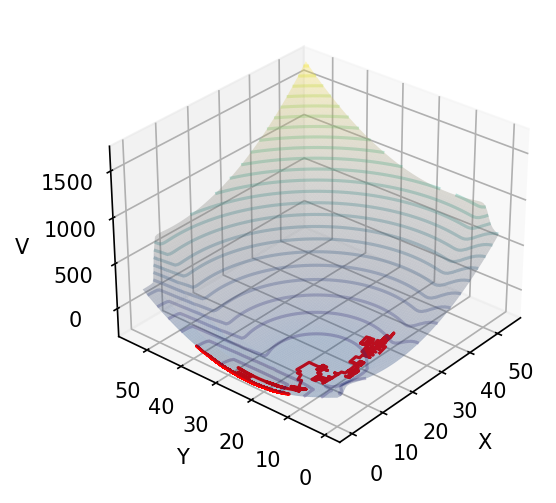

In [26]:
fig = plt.figure(dpi = 150)
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X_grid, Y_grid, V_grid, cmap="cividis", lw=0.5, rstride=1, cstride=1, alpha=0.3)
ax.contour(X_grid, Y_grid, V_grid, 30, linestyles="solid", alpha = 0.3)

ax.plot(X_stoch, Y_stoch, V_stoch, color="red")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('V')

ax.view_init(30, -140)

plt.show()
#plt.savefig('Lscape_tristab_n10_By4-0_stochTraj.png', bbox_inches='tight')

In [27]:
coords = {"X":[X_runs[r][-1] for r in range(runs)], "Y":[Y_runs[r][-1] for r in range(runs)], "V":[V_runs[r][-1] for r in range(runs)]}

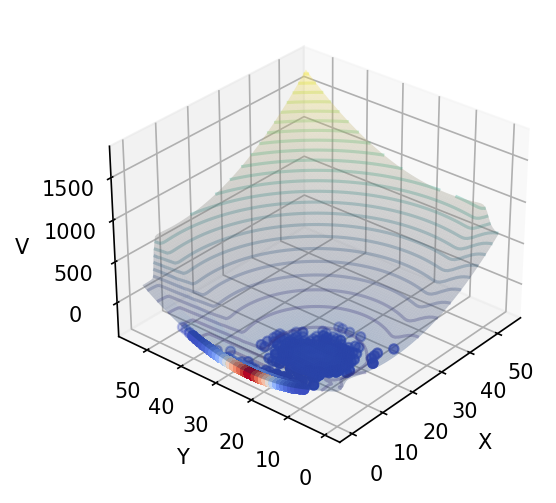

In [28]:
fig = plt.figure(dpi = 150)
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X_grid, Y_grid, V_grid, cmap="cividis", lw=0.5, rstride=1, cstride=1, alpha=0.3)
ax.contour(X_grid, Y_grid, V_grid, 30, linestyles="solid", alpha = 0.3)

xy_sim = np.vstack([coords["X"], coords["Y"]])
density = gaussian_kde(xy_sim)(xy_sim)
ax.scatter(coords["X"], coords["Y"], coords["V"], c = density, cmap = "coolwarm")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('V')

ax.view_init(30, -140)

plt.show()
#plt.savefig('Lscape_tristab_n10_By4-0_stochTraj.png', bbox_inches='tight')

In [29]:
coords = {"X":[X_runs[r][-1] for r in range(runs)], "Y":[Y_runs[r][-1] for r in range(runs)], "V":[V_runs[r][-1] for r in range(runs)]}

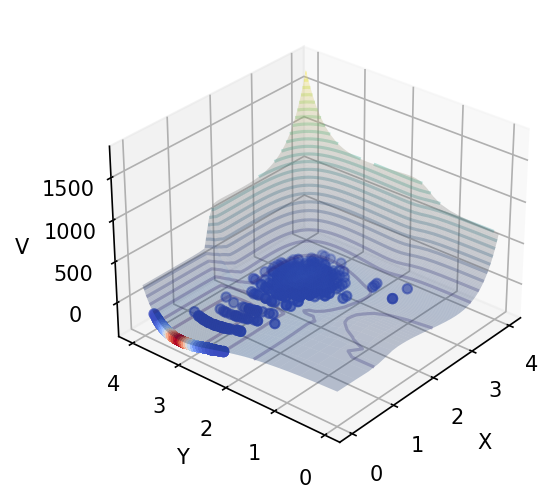

In [31]:
fig = plt.figure(dpi = 150)
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(np.log1p(X_grid), np.log1p(Y_grid), V_grid, cmap="cividis", lw=0.5, rstride=1, cstride=1, alpha=0.3)
ax.contour(np.log1p(X_grid), np.log1p(Y_grid), V_grid, 30, linestyles="solid", alpha = 0.3)

xy_sim = np.vstack([np.log1p(coords["X"]), np.log1p(coords["Y"])])
density = gaussian_kde(xy_sim)(xy_sim)
ax.scatter(np.log1p(coords["X"]), np.log1p(coords["Y"]), coords["V"], c = density, cmap = "coolwarm")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('V')

ax.view_init(30, -140)

plt.show()
#plt.savefig('Lscape_tristab_n10_By4-0_stochTraj.png', bbox_inches='tight')

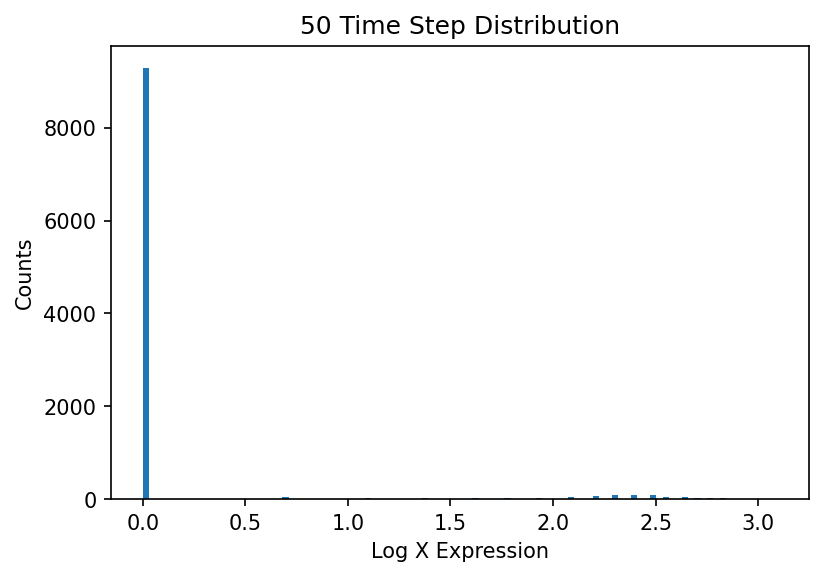

In [32]:
plt.figure(dpi = 150)
plt.title("50 Time Step Distribution")
plt.hist(np.log1p(coords["X"]), bins = 100)
plt.xlabel("Log X Expression")
plt.ylabel("Counts")
plt.show()

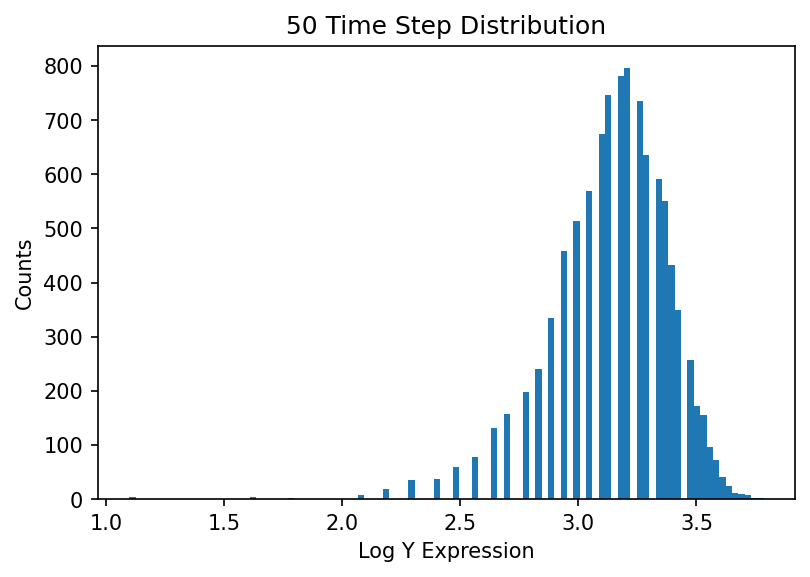

In [33]:
plt.figure(dpi = 150)
plt.title("50 Time Step Distribution")
plt.hist(np.log1p(coords["Y"]), bins = 100)
plt.xlabel("Log Y Expression")
plt.ylabel("Counts")
plt.show()

In [ ]:
#Initialize Number of runs
runs = 10000
#Initialize run dictionaries for t, X, Y, and V
t_runs = {}
X_runs = {}
Y_runs = {}
V_runs = {}

#Run simulations in parallel
pool = mp.Pool(mp.cpu_count())
results = []
results = pool.starmap_async(gillespie_sim, [(r, initials, propensities, stoichiometry, 25) for r in range(runs)]).get()
pool.close()

In [ ]:
# Collect all the results into dictionaries
for result in results:
    r = result[0]
    t_runs[r] = result[1]
    X_stoch, Y_stoch = zip(*result[2])
    X_runs[r] = X_stoch
    Y_runs[r] = Y_stoch
    V_stoch = []
    for i in range(0, len(X_stoch)):
        x_idx = int(X_stoch[i] / x_grid_step)
        y_idx = int(Y_stoch[i] / y_grid_step)
        V_stoch.append(V_grid[y_idx, x_idx])
    V_runs[r] = V_stoch

In [ ]:
coords = {"X":[X_runs[r][-1] for r in range(runs)], "Y":[Y_runs[r][-1] for r in range(runs)], "V":[V_runs[r][-1] for r in range(runs)]}

In [ ]:
fig = plt.figure(dpi = 150)
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(np.log1p(X_grid), np.log1p(Y_grid), V_grid, cmap="cividis", lw=0.5, rstride=1, cstride=1, alpha=0.3)
ax.contour(np.log1p(X_grid), np.log1p(Y_grid), V_grid, 30, linestyles="solid", alpha = 0.3)

xy_sim = np.vstack([np.log1p(coords["X"]), np.log1p(coords["Y"])])
density = gaussian_kde(xy_sim)(xy_sim)
ax.scatter(np.log1p(coords["X"]), np.log1p(coords["Y"]), coords["V"], c = density, cmap = "coolwarm")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('V')

ax.view_init(30, -140)
plt.show()

In [ ]:
plt.figure(dpi = 150)
plt.title("25 Time Step Distribution")
plt.hist(np.log1p(coords["X"]), bins = 100)
plt.xlabel("Log X Expression")
plt.ylabel("Counts")
plt.show()

In [ ]:
plt.figure(dpi = 150)
plt.title("25 Time Step Distribution")
plt.hist(np.log1p(coords["Y"]), bins = 100)
plt.xlabel("Log Y Expression")
plt.ylabel("Counts")
plt.show()